<a href="https://colab.research.google.com/github/cdwangco/SentimentAnalysisProject/blob/main/MLProjectYTSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
#input data source here
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [3]:
df.head()
df[1].value_counts() #we have a balanced data set
df = df[:200]

In [4]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 15.7 MB/s 
     |████████████████████████████████| 5.8 MB 53.1 MB/s 
     |████████████████████████████████| 788 kB 54.0 MB/s 
     |████████████████████████████████| 46 kB 1.7 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 19.7 MB 388 kB/s 
     |████████████████████████████████| 1.6 MB 50.9 MB/s 
     |████████████████████████████████| 1.2 MB 60.8 MB/s 
     |████████████████████████████████| 981 kB 63.9 MB/s 
     |████████████████████████████████| 182 kB 65.8 MB/s 
     |████████████████████████████████| 200 kB 73.9 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 7.6 MB 48.9 MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-py3-none-any.whl size=116702 sha256=f66f9b35718ce006c3c9f8cdcff8e7a3c77a762f3d96781488af617ff5d04e69
  Stor

In [5]:
from scipy.stats.stats import RanksumsResult
# Evaluate the test using Flair baseline
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')




2022-12-01 22:56:57,501 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpx_akovw1


100%|██████████| 265512723/265512723 [00:08<00:00, 31577257.48B/s]

2022-12-01 22:57:06,011 copying /tmp/tmpx_akovw1 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2022-12-01 22:57:06,859 removing temp file /tmp/tmpx_akovw1
2022-12-01 22:57:06,929 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
def predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    # if value == 'POSITIVE':
    #     result = text.to_dict()['labels'][0]['confidence']
    # else:
    #     result = -(text.to_dict()['labels'][0]['confidence'])
    # return round(result, 3)
    return 1 if value == 'POSITIVE' else 0

def flairPredict(sentence):
  # print(text)
  result = predict(sentence)
  return result

In [15]:

df['FlairScore'] = df[0].apply(flairPredict)
df.head()

,0,1,FlairScore
0,"a stirring , funny and finally transporting re...",1,1
1,apparently reassembled from the cutting room f...,0,0
2,they presume their audience wo n't sit still f...,0,0
3,this is a visually stunning rumination on love...,1,1
4,jonathan parker 's bartleby should have been t...,1,0


In [16]:
from textblob import TextBlob
from sklearn.metrics import confusion_matrix, accuracy_score


In [17]:
def getSubj(text):
  return TextBlob(text).sentiment.subjectivity

def getPol(text):
  return TextBlob(text).sentiment.polarity

def binarize(float):
  return 1 if float > 0 else 0
  


In [19]:

data = df.rename(columns={0: 'Comment', 1:'Label'})
data['Polarity'] = data['Comment'].apply(getPol)
data['TextBlob'] = data['Polarity'].apply(binarize)
data.head()

,Comment,Label,FlairScore,Polarity,TextBlob
0,"a stirring , funny and finally transporting re...",1,1,0.125000,1
1,apparently reassembled from the cutting room f...,0,0,-0.275000,0
2,they presume their audience wo n't sit still f...,0,0,0.178571,1
3,this is a visually stunning rumination on love...,1,1,0.500000,1
4,jonathan parker 's bartleby should have been t...,1,0,0.200000,1


In [20]:

!pip install transformers
import transformers as ppb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# Do BERT in parallel to compare baseline performance
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [22]:
tokenized = data['Comment'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(tokenized.head())

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print(np.array(padded).shape)

attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)



0    [101, 1037, 18385, 1010, 6057, 1998, 2633, 182...
1    [101, 4593, 2128, 27241, 23931, 2013, 1996, 62...
2    [101, 2027, 3653, 23545, 2037, 4378, 24185, 10...
3    [101, 2023, 2003, 1037, 17453, 14726, 19379, 1...
4    [101, 5655, 6262, 1005, 1055, 12075, 2571, 376...
Name: Comment, dtype: object
(200, 54)
(200, 54)


In [23]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

features = last_hidden_states[0][:,0,:].numpy()

In [24]:
lr_clf = LogisticRegression()
clf = lr_clf.fit(features,data['Label'])
data['Bert'] = clf.predict(features)
data.head()
print(lr_clf.score(features, data['Label']))

0.97


In [28]:
print('TextBlob Confusion Matrix')
print(confusion_matrix(data['Label'],data['TextBlob']))
textBlobAcc = accuracy_score(data['Label'],data['TextBlob'])
print('accuracy = ', textBlobAcc)

print('BERT Confusion Matrix')
print(confusion_matrix(data['Label'],data['Bert']))
bertAcc = accuracy_score(data['Label'],data['Bert'])
print('accuracy = ',bertAcc)

print('Flair Confusion Matrix')
print(confusion_matrix(data['Label'],data['FlairScore']))
flairAcc = accuracy_score(data['Label'],data['FlairScore'])
print('accuracy = ',flairAcc)

names = ['TextBlob', 'BERT', 'Flair']
accuracies = [textBlobAcc,bertAcc, flairAcc]

TextBlob Confusion Matrix
[[42 45]
 [29 84]]
accuracy =  0.63
BERT Confusion Matrix
[[ 85   2]
 [  4 109]]
accuracy =  0.97
Flair Confusion Matrix
[[ 87   0]
 [  5 108]]
accuracy =  0.975


<BarContainer object of 3 artists>

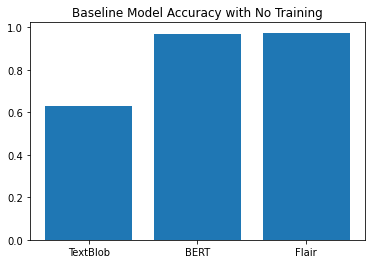

In [27]:
import matplotlib.pyplot as plt

plt.title('Baseline Model Accuracy with No Training')
plt.bar(names,accuracies)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')